# Predicción del rating de Las aplicaciones en Google Play Store

[Edimer David Jaramillo (Sidereus)](https://edimer.github.io/)

![](competencia.PNG)

# Variables

![](variables.PNG)

# Train - Test - Submission

In [38]:
# Importando pandas
import pandas as pd

# Cargando datos
data_train = pd.read_csv("../data/train1.csv")
data_test = pd.read_csv("../data/test1.csv")
data_sub = pd.read_csv("../data/sample_submission.csv")

# Selección de columnnas
mi_train = data_train.drop(["App", "date_update"], axis = 1)
mi_test = data_test.drop(["App", "date_update"], axis = 1)

# Partición de datos
data = mi_train.sample(frac = 0.95, random_state = 786)
data_validation = mi_train.drop(data.index)
data.reset_index(inplace = True, drop = True)
data_validation.reset_index(inplace = True, drop = True)
print('Datos para modelación (train): ' + str(data.shape))
print('Datos para predicción (validation): ' + str(data_validation.shape))

Datos para modelación (train): (5499, 15)
Datos para predicción (validation): (289, 15)


# Configuración *pycaret*

- En este caso voy a cambiar la configuración por defecto de `train_size`, que es 70-30%, voy a cambiarla a 80-20%, para train y test (datos de retención), respecitvamente.
- El año (`newyear`) y el mes (`new_month_num`) los asigno como variables numéricas. Por defecto toma estas dos variables como categóricas. En modelos previos (con R) incluí estas variables como numéricas, por tal motivo las coerciono explícitamente aquí.
- La imputación de los valores ausentes en este caso se hace de forma automática.
- Como el problema es imbalanceado, automaticamente pycaret opta por utilizar muestreo [SPOT](https://pycaret.org/fix-imbalance/) (Synthetic Minority Over-sampling Technique)
- El método de imputación lo voy a cambiar de `mean` a `median` para variables numércias.
- Normalizo y transformo las variables (transformación yeo-johnson). Esto es importante en modelos tales como la regresión logística, naive bayes o análisis discriminante lineal.

In [15]:
from pycaret.classification import *
mi_config = setup(data = data, target = "Rating", session_id = 1992, train_size = 0.8,
                  numeric_features=["new_year", "new_month_num"], numeric_imputation="median",
                 normalize=True, transformation=True, transformation_method="yeo-johnson")

# Comparación de modelos

In [16]:
modelos = compare_models(sort = "AUC")

# Modelos Individuales

## Catboost


In [17]:
mod_catboost = create_model("catboost")

# Gradient Boosting

In [18]:
mod_gbm = create_model("gbc")

# LightGBM

In [19]:
mod_lgbm = create_model("lightgbm")

# XGBoost

In [20]:
mod_xgb = create_model("xgboost")

# Random Forest

In [21]:
mod_rf = create_model("rf")

# Tuning de modelos

## Catboost

- Tiempo de procesamiento: aproximadamente 25 minutos.

In [22]:
tuned_catboost = tune_model(mod_catboost, optimize = "AUC", choose_better=True, n_iter=100)

In [23]:
# Mejores parámetros
plot_model(tuned_catboost, plot = 'parameter')

Parameters
nan_mode                                           Min
eval_metric                                    Logloss
iterations                                        1000
sampling_frequency                             PerTree
leaf_estimation_method                          Newton
grow_policy                              SymmetricTree
penalties_coefficient                                1
boosting_type                                    Plain
model_shrink_mode                             Constant
feature_border_type                       GreedyLogSum
bayesian_matrix_reg                0.10000000149011612
l2_leaf_reg                                          3
random_strength                                      1
rsm                                                  1
boost_from_average                               False
model_size_reg                                     0.5
subsample                            0.800000011920929
use_best_model                                   False
class_names                                     [0, 1]
random_seed                                       1992
depth                                                6
posterior_sampling                               False
border_count                                       254
classes_count                                        0
auto_class_weights                                None
sparse_features_conflict_fraction                    0
leaf_estimation_backtracking            AnyImprovement
best_model_min_trees                                 1
model_shrink_rate                                    0
min_data_in_leaf                                     1
loss_function                                  Logloss
learning_rate                      0.01939300075173378
score_function                                  Cosine
task_type                                          CPU
leaf_estimation_iterations                          10
bootstrap_type                                     MVS
max_leaves                                          64

## Gradient Boosting

- Tiempo de ejecución: aproximadamente 6 minutos.

In [56]:
tuned_gbm = tune_model(mod_gbm, optimize = "AUC", choose_better=True, n_iter=100)

## LightGBM

In [103]:
tuned_lgbm = tune_model(mod_gbm, optimize = "AUC", choose_better=True, n_iter=100)

In [104]:
# Mejores parámetros lightGBM
plot_model(tuned_lgbm, plot = "parameter")

Parameters
ccp_alpha                          0.0
criterion                 friedman_mse
init                              None
learning_rate                    0.052
loss                          deviance
max_depth                            8
max_features                       1.0
max_leaf_nodes                    None
min_impurity_decrease              0.2
min_impurity_split                None
min_samples_leaf                     3
min_samples_split                    9
min_weight_fraction_leaf           0.0
n_estimators                        60
n_iter_no_change                  None
presort                     deprecated
random_state                      1992
subsample                         0.65
tol                             0.0001
validation_fraction                0.1
verbose                              0
warm_start                       False

## XGBoost

In [118]:
tuned_xgb = tune_model(mod_xgb, optimize = "AUC", choose_better=True, n_iter=100)

In [119]:
# Mejores parámetros
plot_model(tuned_xgb, plot = "parameter")

Parameters
objective                binary:logistic
use_label_encoder                   True
base_score                           0.5
booster                           gbtree
colsample_bylevel                      1
colsample_bynode                       1
colsample_bytree                     0.9
gamma                                  0
gpu_id                                -1
importance_type                     gain
interaction_constraints                 
learning_rate                      0.197
max_delta_step                         0
max_depth                              2
min_child_weight                       3
missing                              nan
monotone_constraints                  ()
n_estimators                         300
n_jobs                                -1
num_parallel_tree                      1
random_state                        1992
reg_alpha                           0.01
reg_lambda                        0.0005
scale_pos_weight                    21.3
subsample                            0.9
tree_method                         auto
validate_parameters                    1
verbosity                              0

# Ensamble (Bagging)

- En este caso utilizo 10 estimadores (valor por defecto), sin embargo, se puede cambiar a través del argumento `n_estimators`.
- En [la documentación](https://pycaret.org/ensemble-model/) se puede encontrar más información del ensamble a través de Bagging o Boosting.

## Catboost

- Tiempo de procesamiento: aproximadamente 10 minutos.

In [24]:
bagged_catboost = ensemble_model(tuned_catboost)

## GBM

In [57]:
bagged_gbm = ensemble_model(tuned_gbm)

## LightGBM

- Con este algoritmo utilizo 50 estimadores.

In [105]:
bagged_lgbm = ensemble_model(tuned_lgbm, n_estimators=50)

## XGBoost

- Con este algoritmo utilizo 50 estimadores

In [120]:
bagged_xgb = ensemble_model(tuned_xgb, n_estimators=50)

# Ensamble (Boosting)

## Catboost

In [27]:
boosting_catboost = ensemble_model(tuned_catboost, method = 'Boosting')

## GBM

In [58]:
boosting_gbm = ensemble_model(tuned_gbm, method = 'Boosting')

## LightGBM

- Con este algoritmo utilizo 50 estimadores.

In [107]:
boosting_lgbm = ensemble_model(tuned_lgbm, method = 'Boosting', n_estimators=50)

# Matriz de confusión

## Catboost Tuned

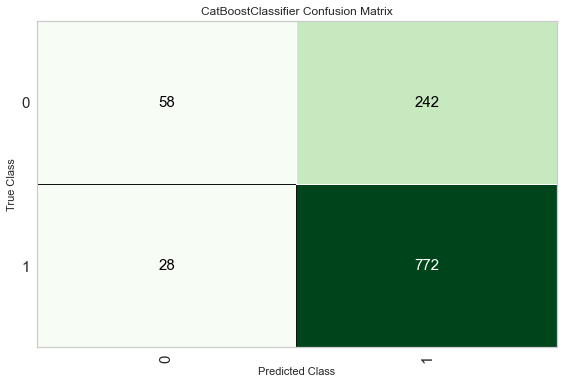

In [28]:
plot_model(tuned_catboost, plot = 'confusion_matrix')

## Catboost Bagging

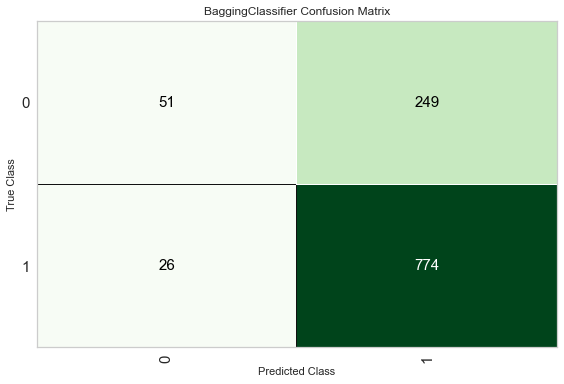

In [29]:
plot_model(bagged_catboost, plot = 'confusion_matrix')

## Catboost Boosting

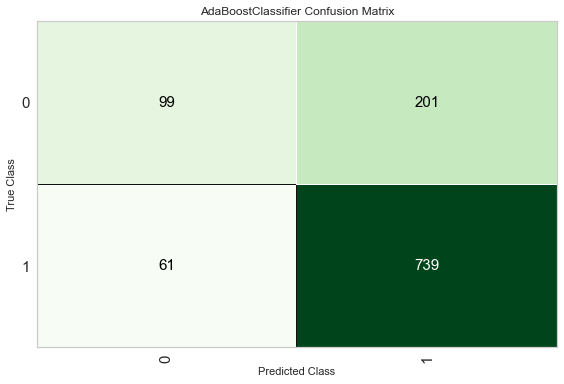

In [30]:
plot_model(boosting_catboost, plot = 'confusion_matrix')

## GBM Tuned

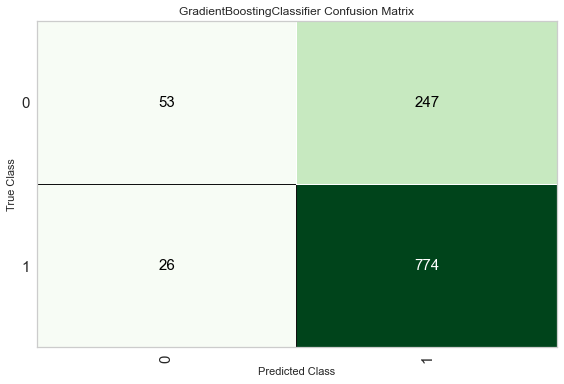

In [60]:
plot_model(tuned_gbm, plot = 'confusion_matrix')

## GBM Bagging

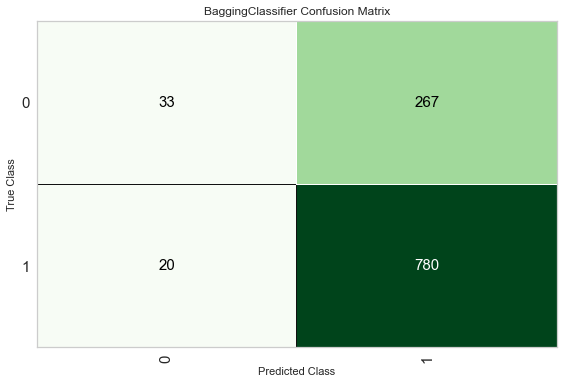

In [61]:
plot_model(bagged_gbm, plot = 'confusion_matrix')

## GBM Boosting

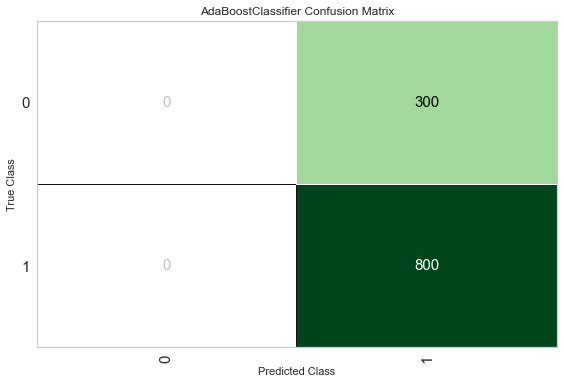

In [62]:
plot_model(boosting_gbm, plot = 'confusion_matrix')

## LightGBM Tuned

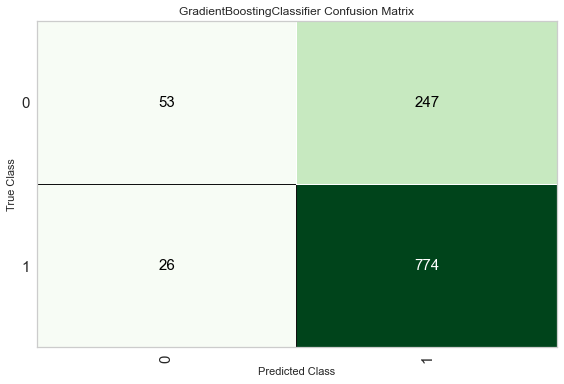

In [108]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

## LightGBM Bagging

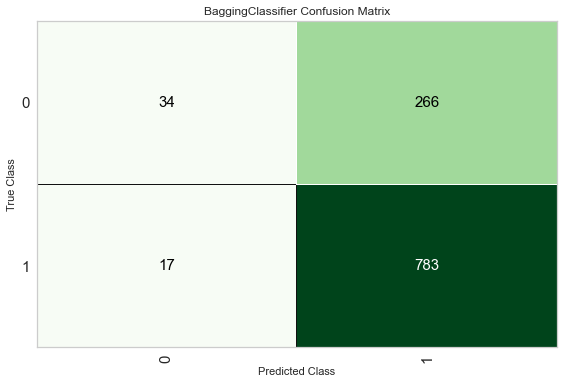

In [109]:
plot_model(bagged_lgbm, plot = 'confusion_matrix')

## LightGBM Boosting

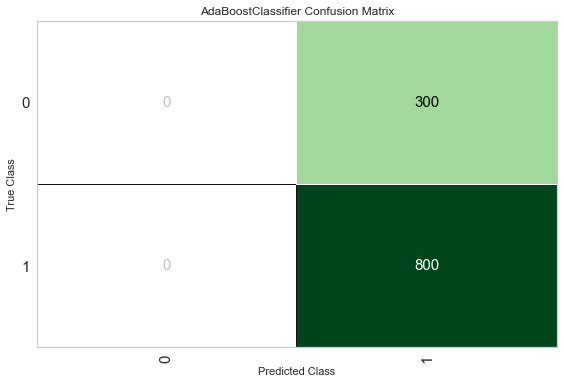

In [110]:
plot_model(boosting_lgbm, plot = 'confusion_matrix')

## XGBoost Tuned

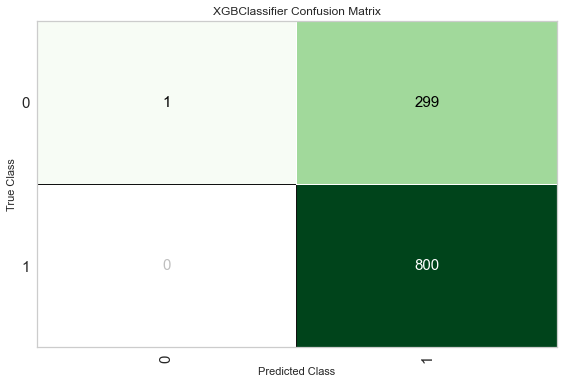

In [122]:
plot_model(tuned_xgb, plot = 'confusion_matrix')

## XGBoost Bagging

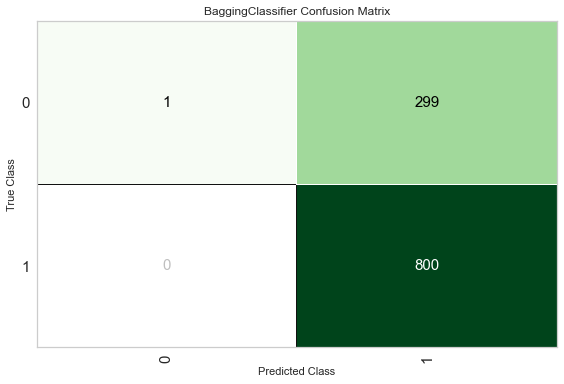

In [123]:
plot_model(bagged_xgb, plot = 'confusion_matrix')

# Finalizando modelos

## Catboost

In [31]:
final_catboost_tuned = finalize_model(tuned_catboost)

In [32]:
final_catboost_bagging = finalize_model(bagged_catboost)

In [33]:
final_catboost_boosting = finalize_model(boosting_catboost)

## GBM

In [63]:
final_gbm_tuned = finalize_model(tuned_gbm)

In [64]:
final_gbm_bagging = finalize_model(bagged_gbm)

In [65]:
final_gbm_boosting = finalize_model(boosting_gbm)

## LightGBM

In [111]:
final_lgbm_tuned = finalize_model(tuned_lgbm)

In [112]:
final_lgbm_bagging = finalize_model(bagged_lgbm)

In [113]:
final_lgbm_boosting = finalize_model(boosting_lgbm)

## XGBoost

In [125]:
final_xgb_tuned = finalize_model(tuned_xgb)

In [126]:
final_xgb_bagging = finalize_model(bagged_xgb)

# Predicción submission

## Catboost Tuned

In [97]:
data_sub2 = data_sub
predict_catboost_tuned = predict_model(final_catboost_tuned, data=mi_test)
data_sub2["rating"] = predict_catboost_tuned["Label"]
data_sub2.to_csv("../submission/sub_15_catboost_tuned.csv", index=False)
data_sub2.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       0
6  5794       1
7  5795       1
8  5796       1
9  5797       0

## Catboost Bagging

In [98]:
data_sub3 = data_sub
predict_catboost_bagging = predict_model(final_catboost_bagging, data=mi_test)
data_sub3["rating"] = predict_catboost_bagging["Label"]
data_sub3.to_csv("../submission/sub_16_catboost_bagging.csv", index=False)
data_sub3.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       0
6  5794       1
7  5795       1
8  5796       1
9  5797       0

## Catboost Boosting

In [99]:
data_sub4 = data_sub
predict_catboost_boosting = predict_model(final_catboost_boosting, data=mi_test)
data_sub4["rating"] = predict_catboost_boosting["Label"]
data_sub4.to_csv("../submission/sub_17_catboost_boosting.csv", index=False)
data_sub4.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       0
6  5794       1
7  5795       1
8  5796       1
9  5797       0

## GBM Tuned

In [100]:
data_sub5 = data_sub
predict_gbm_tuned = predict_model(final_gbm_tuned, data=mi_test)
data_sub5["rating"] = predict_gbm_tuned["Label"]
data_sub5.to_csv("../submission/sub_18_gbm_tuned.csv", index=False)
data_sub5.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       0
6  5794       1
7  5795       1
8  5796       1
9  5797       0

## GBM Bagging

In [101]:
data_sub6 = data_sub
predict_gbm_bagging = predict_model(final_gbm_bagging, data=mi_test)
data_sub6["rating"] = predict_gbm_bagging["Label"]
data_sub6.to_csv("../submission/sub_19_gbm_bagging.csv", index=False)
data_sub6.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       0
6  5794       1
7  5795       1
8  5796       1
9  5797       0

## GBM Boosting

In [102]:
data_sub7 = data_sub
predict_gbm_boosting = predict_model(final_gbm_boosting, data=mi_test)
data_sub7["rating"] = predict_gbm_boosting["Label"]
data_sub7.to_csv("../submission/sub_20_gbm_boosting.csv", index=False)
data_sub7.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       1
6  5794       1
7  5795       1
8  5796       1
9  5797       1

## LightGBM Tuned

In [114]:
data_sub8 = data_sub
predict_lgbm_tuned = predict_model(final_lgbm_tuned, data=mi_test)
data_sub8["rating"] = predict_lgbm_tuned["Label"]
data_sub8.to_csv("../submission/sub_21_lgbm_tuned.csv", index=False)
data_sub8.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       0
6  5794       1
7  5795       1
8  5796       1
9  5797       0

## LightGBM Bagging

In [115]:
data_sub9 = data_sub
predict_lgbm_bagging = predict_model(final_lgbm_bagging, data=mi_test)
data_sub9["rating"] = predict_lgbm_bagging["Label"]
data_sub9.to_csv("../submission/sub_22_lgbm_bagging.csv", index=False)
data_sub9.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       0
6  5794       1
7  5795       1
8  5796       1
9  5797       0

## LightGBM Boosting

In [117]:
data_sub10 = data_sub
predict_lgbm_boosting = predict_model(final_lgbm_boosting, data=mi_test)
data_sub10["rating"] = predict_lgbm_boosting["Label"]
data_sub10.to_csv("../submission/sub_23_lgbm_boosting.csv", index=False)
data_sub10.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       1
6  5794       1
7  5795       1
8  5796       1
9  5797       1

## XGBoost Tuned

In [127]:
data_sub11 = data_sub
predict_xgb_tuned = predict_model(final_xgb_tuned, data=mi_test)
data_sub11["rating"] = predict_xgb_tuned["Label"]
data_sub11.to_csv("../submission/sub_24_xgb_tuned.csv", index=False)
data_sub11.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       1
6  5794       1
7  5795       1
8  5796       1
9  5797       1

## XGBoost Bagging

In [128]:
data_sub12 = data_sub
predict_xgb_bagging = predict_model(final_xgb_bagging, data=mi_test)
data_sub12["rating"] = predict_xgb_bagging["Label"]
data_sub12.to_csv("../submission/sub_25_xgb_bagging.csv", index=False)
data_sub12.head(10)

id  rating
0  5788       1
1  5789       1
2  5790       1
3  5791       1
4  5792       1
5  5793       1
6  5794       1
7  5795       1
8  5796       1
9  5797       1